# Chapter 6
## Deep learning


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Get familiar with a state-of-the-art framework for deep learning
1. Implement and run a convolutional neural network
1. See what convolution does

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import os, json
import scipy.signal as ss

C:\Users\marcv\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
mlp_output_folder = "chainermlp/"
cnn_output_folder = "chainercnn/"

def get_losses(output_folder):

    with open(os.path.join(output_folder, "log")) as data_file:
        data = json.load(data_file)

    training_loss = map(lambda x: x["main/loss"], data)
    validation_loss = map(lambda x: x["validation/main/loss"], data)
    
    return training_loss, validation_loss

When working on a state-of-the-art neural network project you would rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a convolutional neural network in the Chainer framework. At the moment we use this framework for most of the work in our group as it is flexible and has quite intuitive and pythonic syntax.  

Due to the popularity of deep learning various [Neural Network Frameworks](http://chainer.readthedocs.io/en/latest/comparison.html) exist, and it is unclear whether one of them will "win". Among those mentioned, Chainer and PyTorch (which is quite popular right now) have very similar syntax, and in fact PyTorch started as a fork from Chainer, reimplementing core functionality such as autograd in C++. This makes it faster, but less versatile. Google is developing and promoting the TensorFlow framework, which is fast for statically defined neural network flows. 


In this assignment you will follow a Chainer tutorial for implementing a standard multi-layer perceptron and a convolutional neural network. You will first copy the tutorial code and then make several adaptations. For a few steps you should consult the documentation or example code to check out how to implement them. 

### Exercise 1 (3 points)

Read the tutorial at https://docs.chainer.org/en/stable/tutorial/basic.html. As you go along, transfer the code for the Multi-Layer Perceptron example on MNIST into the notebook (and try running it). Use the variant that makes use of the Trainer framework, i.e. you do not need to handle the gradients yourself. 

Change the MLP training code so that it is similar to the MLP we implemented in the MLP exercise, i.e. it should use: 

1. A single hidden layer of 16 units (that is, two weight layers)
1. ReLU activation function
1. Stochastic Gradient Descent with a learning rate of 0.001 as optimizer
1. Training should do 50 iterations over the training set

For **evaluating the model**, set up the `trainer` object as follows: 
1. When initializing the `trainer` object, set the output folder to be `mlp_output_folder`.
1. Extend your `trainer` object with an `Evaluator` object that evaluates your `model` on the test set. 
1. Extend your `trainer` object with the `LogReport()` object. 
1. For printing the current model performance underneath the cell, extend the `trainer` object with a `PrintReport` object. Use the keys `"epoch"`, `"main/accuracy"`, `"validation/main/accuracy"`,  `"main/loss"` and `"validation/main/loss"`.
1. For plotting the accuracy and losses over epochs, extend the `trainer` object with a `PlotReport` object. Use the same keys as for `PrintReport` except `"epoch"`. Set the file name to `mlp_plot.png`.

Embed the generated `mlp_plot.png` underneath your code via `<img src='chainermlp/mlp_plot.png'>`. **Please additionally attach `mlp_plot.png` to your submission.**

In [4]:
# Load the MNIST data set as 784-length vectors (default): 
train, test = datasets.get_mnist()
print "Shape of a single example:", train[0][0].shape

Shape of a single example: (784,)


### Solution 1

In [29]:
# Your MLP, including output
    ### Add your code here ###
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

# n_units=16
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
           # the size of the inputs to each layer will be inferred
             self.l1 = L.Linear(None, n_units)  # n_in -> n_units
             self.l2 = L.Linear(None, n_units)  # n_units -> n_units
             self.l3 = L.Linear(None, n_out)    # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y



In [30]:
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
         y = self.predictor(x)
         loss = F.softmax_cross_entropy(y, t)
         accuracy = F.accuracy(y, t)
         report({'loss': loss, 'accuracy': accuracy}, self)
         return loss

In [31]:
model = L.Classifier(MLP(16, 10))  # the input size, 784, is inferred
optimizer = optimizers.SGD(lr=0.001)
optimizer.setup(model)

In [32]:
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (50, 'epoch'), out='mlp_output_folder')



In [33]:
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], file_name='accuracy.png'))
trainer.run()

epoch       main/accuracy  validation/main/accuracy
     total [..................................................]  0.33%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  0.67%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 50 epochs
    353.36 iters/sec. Estimated time to finish: 0:01:24.333998.
     total [..................................................]  1.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 50 epochs
    355.87 iters/sec. Estimated time to finish: 0:01:23.457005.
     total [..................................................]  1.33%
this epoch [#################################.................] 66.67%
       400 iter, 0 epoch / 50 epochs
    349.65 iters/sec. Estimated time to finish:

     total [#####.............................................] 11.33%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 50 epochs
    217.95 iters/sec. Estimated time to finish: 0:02:02.045637.
     total [#####.............................................] 11.67%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 50 epochs
    219.06 iters/sec. Estimated time to finish: 0:02:00.972501.
6           0.585067       0.6068                    
     total [######............................................] 12.00%
this epoch [..................................................]  0.00%
      3600 iter, 6 epoch / 50 epochs
    218.83 iters/sec. Estimated time to finish: 0:02:00.640457.
     total [######............................................] 12.33%
this epoch [########..........................................] 16.67%
      3700 iter, 6 epoch / 50 epochs
    216.15 iters/sec. Estimated time t

     total [###########.......................................] 22.33%
this epoch [########..........................................] 16.67%
      6700 iter, 11 epoch / 50 epochs
    218.04 iters/sec. Estimated time to finish: 0:01:46.862273.
     total [###########.......................................] 22.67%
this epoch [################..................................] 33.33%
      6800 iter, 11 epoch / 50 epochs
    218.55 iters/sec. Estimated time to finish: 0:01:46.155582.
     total [###########.......................................] 23.00%
this epoch [#########################.........................] 50.00%
      6900 iter, 11 epoch / 50 epochs
    219.04 iters/sec. Estimated time to finish: 0:01:45.458294.
     total [###########.......................................] 23.33%
this epoch [#################################.................] 66.67%
      7000 iter, 11 epoch / 50 epochs
    219.51 iters/sec. Estimated time to finish: 0:01:44.776667.
     total [###########.

     total [################..................................] 33.33%
this epoch [#################################.................] 66.67%
     10000 iter, 16 epoch / 50 epochs
    219.25 iters/sec. Estimated time to finish: 0:01:31.218182.
     total [################..................................] 33.67%
this epoch [#########################################.........] 83.33%
     10100 iter, 16 epoch / 50 epochs
    219.74 iters/sec. Estimated time to finish: 0:01:30.562910.
17          0.849233       0.8611                    
     total [#################.................................] 34.00%
this epoch [..................................................]  0.00%
     10200 iter, 17 epoch / 50 epochs
    218.58 iters/sec. Estimated time to finish: 0:01:30.583020.
     total [#################.................................] 34.33%
this epoch [########..........................................] 16.67%
     10300 iter, 17 epoch / 50 epochs
    216.47 iters/sec. Estimated ti

     total [######################............................] 44.33%
this epoch [########..........................................] 16.67%
     13300 iter, 22 epoch / 50 epochs
    219.67 iters/sec. Estimated time to finish: 0:01:16.023410.
     total [######################............................] 44.67%
this epoch [################..................................] 33.33%
     13400 iter, 22 epoch / 50 epochs
    219.81 iters/sec. Estimated time to finish: 0:01:15.520040.
     total [######################............................] 45.00%
this epoch [#########################.........................] 50.00%
     13500 iter, 22 epoch / 50 epochs
    219.71 iters/sec. Estimated time to finish: 0:01:15.098100.
     total [######################............................] 45.33%
this epoch [#################################.................] 66.67%
     13600 iter, 22 epoch / 50 epochs
    220.14 iters/sec. Estimated time to finish: 0:01:14.498640.
     total [############

     total [###########################.......................] 55.33%
this epoch [#################################.................] 66.67%
     16600 iter, 27 epoch / 50 epochs
    217.43 iters/sec. Estimated time to finish: 0:01:01.627940.
     total [###########################.......................] 55.67%
this epoch [#########################################.........] 83.33%
     16700 iter, 27 epoch / 50 epochs
    218.73 iters/sec. Estimated time to finish: 0:01:00.806270.
28          0.879683       0.8841                    
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
     16800 iter, 28 epoch / 50 epochs
    217.86 iters/sec. Estimated time to finish: 0:01:00.588000.
     total [############################......................] 56.33%
this epoch [########..........................................] 16.67%
     16900 iter, 28 epoch / 50 epochs
    216.43 iters/sec. Estimated ti

     total [#################################.................] 66.33%
this epoch [########..........................................] 16.67%
     19900 iter, 33 epoch / 50 epochs
    218.16 iters/sec. Estimated time to finish: 0:00:46.296380.
     total [#################################.................] 66.67%
this epoch [################..................................] 33.33%
     20000 iter, 33 epoch / 50 epochs
    218.14 iters/sec. Estimated time to finish: 0:00:45.842000.
     total [#################################.................] 67.00%
this epoch [#########################.........................] 50.00%
     20100 iter, 33 epoch / 50 epochs
    218.02 iters/sec. Estimated time to finish: 0:00:45.409320.
     total [#################################.................] 67.33%
this epoch [#################################.................] 66.67%
     20200 iter, 33 epoch / 50 epochs
    218.74 iters/sec. Estimated time to finish: 0:00:44.801680.
     total [############

     total [######################################............] 77.33%
this epoch [#################################.................] 66.67%
     23200 iter, 38 epoch / 50 epochs
    218.71 iters/sec. Estimated time to finish: 0:00:31.090960.
     total [######################################............] 77.67%
this epoch [#########################################.........] 83.33%
     23300 iter, 38 epoch / 50 epochs
    220.36 iters/sec. Estimated time to finish: 0:00:30.404600.
39          0.892583       0.8944                    
     total [#######################################...........] 78.00%
this epoch [..................................................]  0.00%
     23400 iter, 39 epoch / 50 epochs
    219.27 iters/sec. Estimated time to finish: 0:00:30.099300.
     total [#######################################...........] 78.33%
this epoch [########..........................................] 16.67%
     23500 iter, 39 epoch / 50 epochs
    217.69 iters/sec. Estimated ti

     total [############################################......] 88.33%
this epoch [########..........................................] 16.67%
     26500 iter, 44 epoch / 50 epochs
    219.03 iters/sec. Estimated time to finish: 0:00:15.979250.
     total [############################################......] 88.67%
this epoch [################..................................] 33.33%
     26600 iter, 44 epoch / 50 epochs
    219.04 iters/sec. Estimated time to finish: 0:00:15.522360.
     total [############################################......] 89.00%
this epoch [#########################.........................] 50.00%
     26700 iter, 44 epoch / 50 epochs
    219.26 iters/sec. Estimated time to finish: 0:00:15.050640.
     total [############################################......] 89.33%
this epoch [#################################.................] 66.67%
     26800 iter, 44 epoch / 50 epochs
     220.3 iters/sec. Estimated time to finish: 0:00:14.525440.
     total [############

     total [#################################################.] 99.33%
this epoch [#################################.................] 66.67%
     29800 iter, 49 epoch / 50 epochs
    219.27 iters/sec. Estimated time to finish: 0:00:00.912100.
     total [#################################################.] 99.67%
this epoch [#########################################.........] 83.33%
     29900 iter, 49 epoch / 50 epochs
    220.72 iters/sec. Estimated time to finish: 0:00:00.453060.
50          0.899933       0.9022                    
     total [##################################################] 100.00%
this epoch [..................................................]  0.00%
     30000 iter, 50 epoch / 50 epochs
    219.87 iters/sec. Estimated time to finish: 0:00:00.


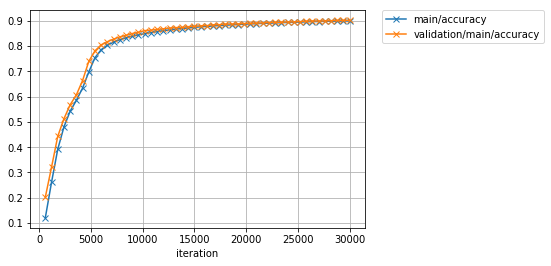

In [63]:
from IPython.display import Image
Image(filename="mlp_output_folder/accuracy.png")


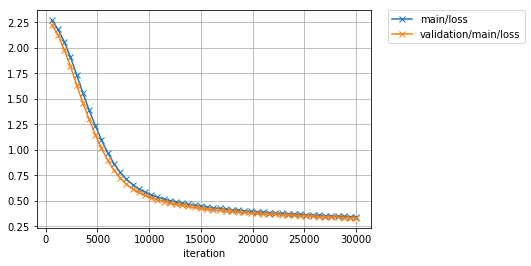

In [64]:
Image(filename="mlp_output_folder/loss.png")

Embed `mlp_plot.png`: 


### Exercise 2  (0.5 points)

The input layer weights that the MLP has learned can be found in `model.predictor.l1.W.data`. Plot them below (as we did in the MLP and autoencoder exercises). 

### Solution 2

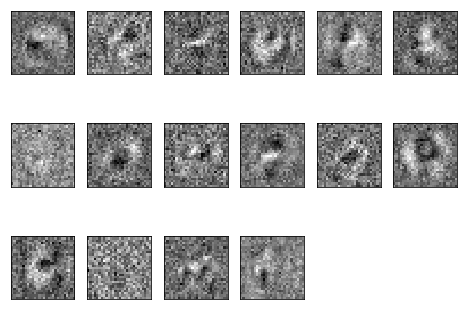

In [34]:
# Plot the weights
    ### Add your code here. ###
W1=model.predictor.l1.W.data
nhidden = W1.shape[0]

plt.figure(figsize=([8,10]))
for i in range(nhidden):    
    plt.subplot(5,6,i+1)
    fig = plt.imshow(W1[i, :].reshape([28,28]).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

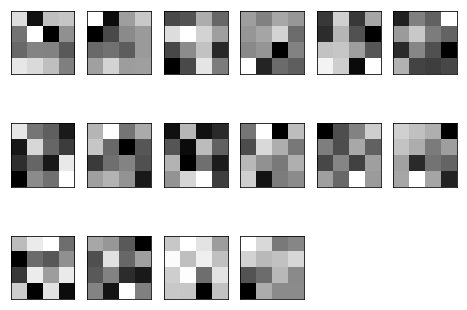

In [35]:
W2=model.predictor.l2.W.data

nhidden = W2.shape[0]

plt.figure(figsize=([8,10]))
for i in range(nhidden):    
    plt.subplot(5,6, i+1)
    fig = plt.imshow(W2[i, :].reshape([4,4]).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    

### Exercise 3: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on an image. We first choose an image: 

[]

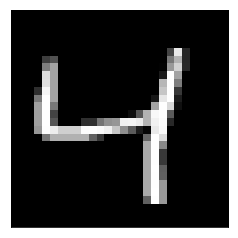

In [36]:
image = train[2][0].reshape((28, 28))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
ax.set_xticks([], []) ; ax.set_yticks([], [])

1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolved2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 3

In [37]:
from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt



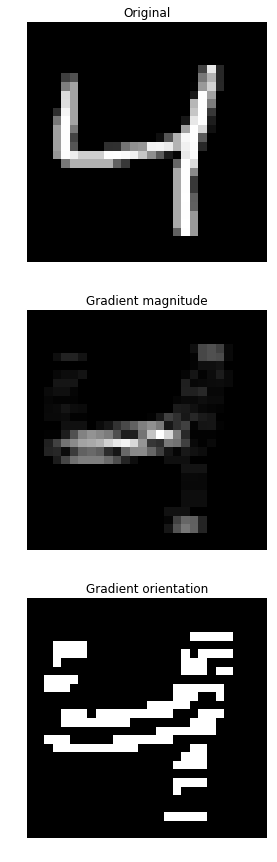

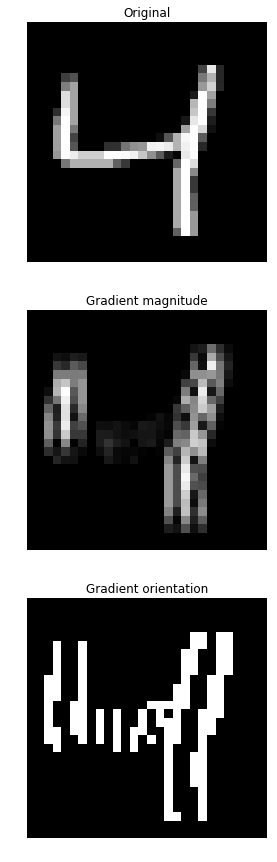

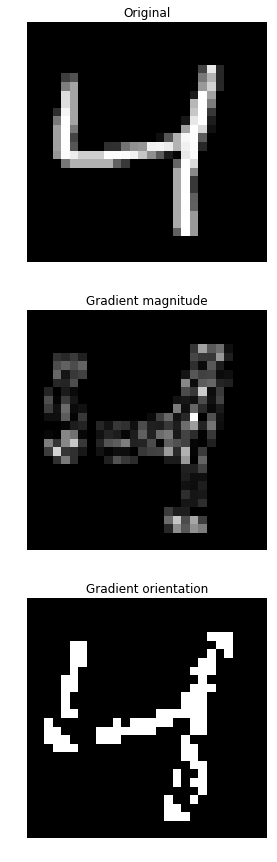

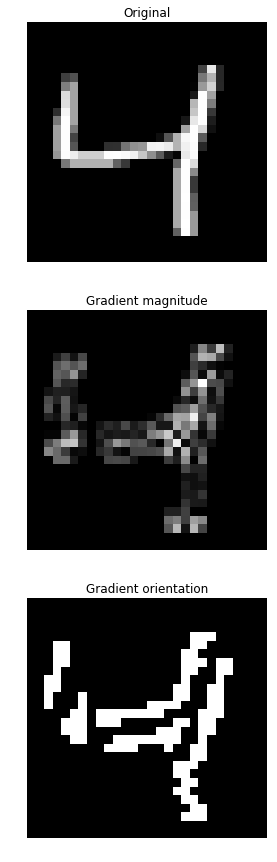

In [38]:
# 1. Create kernels
kernel_template = [ [-1.0, -1.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0, -1.0, -1.0] ]   # example: point detector
    ### Add your code here. ###
kernel_horizontal = [ [-1.0, -1.0, -1.0], 
                    [2.0,  2.0, 2.0], 
                    [-1.0, -1.0, -1.0] ]
    
kernel_vertical = [ [-1.0, 2.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0, 2.0, -1.0] ]
    
kernel_diagonal1= [ [2.0, -1.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0, -1.0, 2.0] ]
    
kernel_diagonal2= [ [-1.0, -1.0, 2.0], 
                    [-1.0,  2.0, -1.0], 
                    [2.0, -1.0, -1.0] ]
    


#Horizontal
ascent = misc.ascent()
grad = signal.convolve2d(image, kernel_horizontal, boundary='symm', mode='same')

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='gray') 
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()


#Vertical
ascent = misc.ascent()
grad = signal.convolve2d(image, kernel_vertical, boundary='symm', mode='same')

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='gray') 
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()


#Diagonal1
ascent = misc.ascent()
grad = signal.convolve2d(image, kernel_diagonal1, boundary='symm', mode='same')

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='gray') 
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()


#Diagonal2
ascent = misc.ascent()
grad = signal.convolve2d(image, kernel_diagonal2, boundary='symm', mode='same')

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='gray') 
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()







### Exercise 4 (3 points)

We want to train a convolutional neural network (CNN) next. Check [this project](https://github.com/vdumoulin/conv_arithmetic) to get intuition for the operations in convolutional neural network layers. 


1. Create `class CNN(Chain)` that should contain the new model. It will be similar to the `MLP` class, so you can start by copying the code of the MLP model class. 
1. The network should have one [2D-convolutional layer](https://docs.chainer.org/en/stable/reference/links.html). The first layer `conv1` should have 4x4 kernels, a stride of 1 and 10 output channels. As in the MLP, a second `Linear` layer should connect with the output units. 
1. Use ReLU activation functions on the convolutional layer activation.
1. Add 2D max-pooling with a `(2,2)` pooling window after the convolutional layer. 
1. Copy the rest of the training code underneath and adapt it so that it uses your `CNN` model. Change the plot file name to `cnn_plot.png`. Run the model for 30 full iterations through the training set and embed `cnn_plot.png` as before. The output directory should be `cnn_output_folder` now. **Please additionally attach `cnn_plot.png` to your submission.**

This will take a while to run. You can test the code by reducing the number of output channels of `conv1` first.  Usually you would train ConvNets on GPUs, which implement many of the linear algebra operations that are used here much more efficiently. 

In [44]:
# Load the MNIST data set in shape 1x28x28-length (the 2D shape is necessary for the convolutional layer): 
train, test = datasets.get_mnist(ndim=3)
print "Shape of a single example:", train[0][0].shape

Shape of a single example: (1, 28, 28)


In [46]:
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

In [47]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=10, ksize=4, stride=1)
            self.l2 = L.Linear(None, 10)
            
    def __call__(self, x):
        h1 = F.relu(self.conv1(x))
        t = F.max_pooling_2d(h1, 2, 2)
        y = self.l2(t)
        return y       
            
            

### Solution 4

In [48]:
# Your CNN, including output
    ### Add your code here. ###
model = L.Classifier(CNN())  # the input size, 784, is inferred
optimizer = optimizers.SGD(lr=0.001)
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (30, 'epoch'), out='cnn_output_folder')

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], file_name='cnn_loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], file_name='cnn_accuracy.png'))
trainer.run()



epoch       main/accuracy  validation/main/accuracy
     total [..................................................]  0.56%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 30 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  1.11%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 30 epochs
    12.173 iters/sec. Estimated time to finish: 0:24:22.269985.
     total [..................................................]  1.67%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 30 epochs
     13.58 iters/sec. Estimated time to finish: 0:21:43.339500.
     total [#.................................................]  2.22%
this epoch [#################################.................] 66.67%
       400 iter, 0 epoch / 30 epochs
    14.016 iters/sec. Estimated time to finish:

     total [#########.........................................] 18.89%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 30 epochs
      12.5 iters/sec. Estimated time to finish: 0:19:28.035393.
     total [#########.........................................] 19.44%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 30 epochs
    12.563 iters/sec. Estimated time to finish: 0:19:14.195735.
6           0.883933       0.8938                    
     total [##########........................................] 20.00%
this epoch [..................................................]  0.00%
      3600 iter, 6 epoch / 30 epochs
    12.442 iters/sec. Estimated time to finish: 0:19:17.348571.
     total [##########........................................] 20.56%
this epoch [########..........................................] 16.67%
      3700 iter, 6 epoch / 30 epochs
    12.468 iters/sec. Estimated time t

     total [##################................................] 37.22%
this epoch [########..........................................] 16.67%
      6700 iter, 11 epoch / 30 epochs
    12.887 iters/sec. Estimated time to finish: 0:14:36.873151.
     total [##################................................] 37.78%
this epoch [################..................................] 33.33%
      6800 iter, 11 epoch / 30 epochs
    12.919 iters/sec. Estimated time to finish: 0:14:26.955224.
     total [###################...............................] 38.33%
this epoch [#########################.........................] 50.00%
      6900 iter, 11 epoch / 30 epochs
     12.95 iters/sec. Estimated time to finish: 0:14:17.171382.
     total [###################...............................] 38.89%
this epoch [#################################.................] 66.67%
      7000 iter, 11 epoch / 30 epochs
    12.981 iters/sec. Estimated time to finish: 0:14:07.408116.
     total [############

     total [###########################.......................] 55.56%
this epoch [#################################.................] 66.67%
     10000 iter, 16 epoch / 30 epochs
    13.028 iters/sec. Estimated time to finish: 0:10:14.047677.
     total [############################......................] 56.11%
this epoch [#########################################.........] 83.33%
     10100 iter, 16 epoch / 30 epochs
    13.035 iters/sec. Estimated time to finish: 0:10:06.038230.
17          0.907967       0.9161                    
     total [############################......................] 56.67%
this epoch [..................................................]  0.00%
     10200 iter, 17 epoch / 30 epochs
    12.972 iters/sec. Estimated time to finish: 0:10:01.282500.
     total [############################......................] 57.22%
this epoch [########..........................................] 16.67%
     10300 iter, 17 epoch / 30 epochs
    12.955 iters/sec. Estimated ti

     total [####################################..............] 73.89%
this epoch [########..........................................] 16.67%
     13300 iter, 22 epoch / 30 epochs
    13.023 iters/sec. Estimated time to finish: 0:06:00.895610.
     total [#####################################.............] 74.44%
this epoch [################..................................] 33.33%
     13400 iter, 22 epoch / 30 epochs
     13.03 iters/sec. Estimated time to finish: 0:05:53.026540.
     total [#####################################.............] 75.00%
this epoch [#########################.........................] 50.00%
     13500 iter, 22 epoch / 30 epochs
    13.032 iters/sec. Estimated time to finish: 0:05:45.312450.
     total [#####################################.............] 75.56%
this epoch [#################################.................] 66.67%
     13600 iter, 22 epoch / 30 epochs
    13.102 iters/sec. Estimated time to finish: 0:05:35.822520.
     total [############

     total [##############################################....] 92.22%
this epoch [#################################.................] 66.67%
     16600 iter, 27 epoch / 30 epochs
    13.176 iters/sec. Estimated time to finish: 0:01:46.253980.
     total [##############################################....] 92.78%
this epoch [#########################################.........] 83.33%
     16700 iter, 27 epoch / 30 epochs
    13.166 iters/sec. Estimated time to finish: 0:01:38.739810.
28          0.916917       0.923                     
     total [##############################################....] 93.33%
this epoch [..................................................]  0.00%
     16800 iter, 28 epoch / 30 epochs
    13.089 iters/sec. Estimated time to finish: 0:01:31.682040.
     total [##############################################....] 93.89%
this epoch [########..........................................] 16.67%
     16900 iter, 28 epoch / 30 epochs
    13.058 iters/sec. Estimated ti

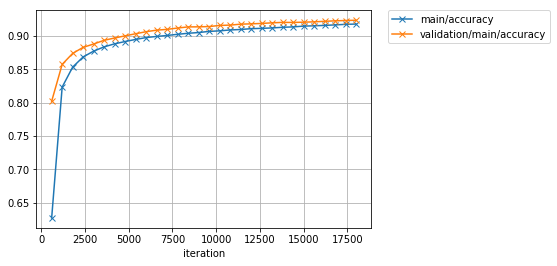

In [68]:
Image(filename="cnn_output_folder/cnn_accuracy.png")

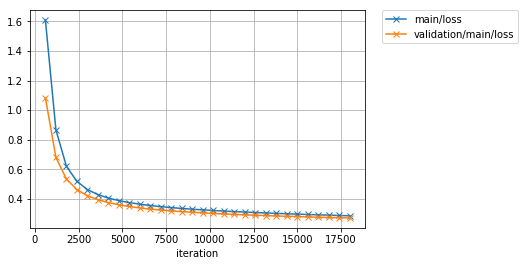

In [69]:
Image(filename="cnn_output_folder/cnn_loss.png")

Embed `cnn_plot.png`: 

### Exercise 5 (0.5 points)
The input layer weights that the ConvNet has learned can be found in `model.predictor.conv1.W.data`. Plot them below (as we did in the MLP and autoencoder exercises).

### Solution 5

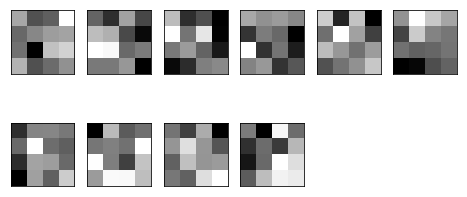

In [49]:
# Plot the weights
    ### Add your code here. ###
    
  
W=model.predictor.conv1.W.data
nhidden = W.shape[0]

plt.figure(figsize=([8,10]))
for i in range(nhidden):    
    plt.subplot(5,6,i+1)
    fig = plt.imshow(W[i, :].reshape([4,4]).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)



### Exercise 6 (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 

1. The main difference of the models is the type of the first layer. What leads to the success of the first layer of the better-performing model? 

1. Explain ways in which the convolution operation and the resulting feature maps are biologically plausible (1 way) and biologically implausible (1 way). 

### Solution 6
1. CNN had a better performance than MLP, on the MNIST digits data set. Speed of training is way slower for CNN, than for MLP. However it is more accurate, as you can see in the graphs. 
2. The CNN networks works the best if there is a pattern in data which is repeated in other locations, like in images. And images are used in the MNIST digits data set, there is symmetry in the digits images; a similar pattern, which repeats it self, allowing the CNN to be more accurate. This leads to a greater succes of the first layer than the MLP. 

3.
Biologically implausible: It uses a purely linear operation, biological neurons however interleave linear and non-linear operations.



Biologically plausible: it uses an activation map, in which the filters get excited when it seaas certain shapes/colors and forms, just like in the human brain, certain groups of neurons get excited when a certain colour, form of shape is seen.



You can play around further with your code for this assignment by replacing the MNIST dataset with a more interesting / difficult to solve data set. For instance, you could use: 

`chainer.datasets.get_cifar10()`  ([CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) - photos of 10 natural object classes)

and 

`chainer.datasets.get_svhn()`  ([SVHN](http://ufldl.stanford.edu/housenumbers/) - house numbers from Google StreetView)